# Using SageMaker Experiments to Train, Tune, and Deploy a Model

---
## Runtime

This notebook takes approximately 60 minutes to run.

---
## Contents
1. [Introduction](##Introduction)
2. [Setup](##Setup)
3. [Prepare the Dataset](##Prepare-the-Dataset)
4. [Create an Experiment](##Create-an-Experiment)
5. [Train the XGBoost Model](##Train-the-XGBoost-Model)
  1. [Automatic Model Tuning](##Automatic-Model-Training)
6. [Lab Cleanup](##Lab-Cleanup)
---
## Introduction

This notebook demonstrates the use of Amazon [SageMaker Experiments Python SDK](https://sagemaker-experiments.readthedocs.io/en/latest/) and SageMaker’s implementation of the XGBoost algorithm to train and deploy a model.

---

## Setup

In [51]:
!pip install sagemaker-experiments

In [52]:
import boto3
import io
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import sagemaker
import sys
import time
import zipfile

from IPython.display import display
from IPython.display import Image
from sagemaker.analytics import ExperimentAnalytics
from sagemaker.inputs import TrainingInput
from sagemaker.session import Session
from sagemaker.xgboost.estimator import XGBoost
from smexperiments.experiment import Experiment
from smexperiments.tracker import Tracker
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from time import gmtime, strftime

role = sagemaker.get_execution_role()
region = boto3.Session().region_name
sess = boto3.Session()
sm = sess.client('sagemaker')
bucket = sagemaker.Session().default_bucket()
prefix = 'sagemaker/lab-xgboost-experiments'

## Prepare the Dataset

In [53]:
adult_columns = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Marital Status",
                 "Occupation", "Relationship", "Ethnic group", "Sex", "Capital Gain", "Capital Loss",
                 "Hours per week", "Country", "Target"]

!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data -O /tmp/adult.data

!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test -O /tmp/adult.test

--2022-07-04 14:43:05--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3.8M) [application/x-httpd-php]
Saving to: ‘/tmp/adult.data’

/tmp/adult.data     100%[===================>]   3.79M  14.6MB/s    in 0.3s    

2022-07-04 14:43:06 (14.6 MB/s) - ‘/tmp/adult.data’ saved [3974305/3974305]

--2022-07-04 14:43:06--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2003153 (1.9M) [application/x-httpd-php]
Saving to: ‘/tmp/adult.test’

/tmp/adult.test     100%[===================>]   1.91M  8.90MB/s    in

In [54]:
data = pd.read_csv('/tmp/adult.data')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 20)
data

,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32555,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32556,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32557,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32558,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [55]:
training_data = pd.read_csv("/tmp/adult.data",
                             names=adult_columns,
                             sep=r'\s*,\s*',
                             engine='python',
                             na_values="?").dropna()

testing_data = pd.read_csv("/tmp/adult.data",
                            names=adult_columns,
                            sep=r'\s*,\s*',
                            engine='python',
                            na_values="?",
                            skiprows=1).dropna()

training_data.head()

,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [56]:
from sklearn import preprocessing
def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == object:
            encoders[column] = preprocessing.LabelEncoder()
            #  print('Column:', column, result[column])
            result[column] = encoders[column].fit_transform(result[column].fillna('None'))
    return result, encoders

training_data = pd.concat([training_data['Target'], training_data.drop(['Target'], axis=1)], axis=1)
training_data, _ = number_encode_features(training_data)
training_data.to_csv('train_data.csv', index=False, header=False)

testing_data = pd.concat([testing_data['Target'], testing_data.drop(['Target'], axis=1)], axis=1)
testing_data, _ = number_encode_features(testing_data)
testing_data.to_csv('test_data.csv', index=False, header=False)

In [57]:
training_data.head()

,Target,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,0,39,5,77516,9,13,4,0,1,4,1,2174,0,40,38
1,0,50,4,83311,9,13,2,3,0,4,1,0,0,13,38
2,0,38,2,215646,11,9,0,5,1,4,1,0,0,40,38
3,0,53,2,234721,1,7,2,5,0,2,1,0,0,40,38
4,0,28,2,338409,9,13,2,9,5,2,0,0,0,40,4


In [58]:
testing_data.head()

,Target,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,0,50,4,83311,9,13,2,3,0,4,1,0,0,13,38
1,0,38,2,215646,11,9,0,5,1,4,1,0,0,40,38
2,0,53,2,234721,1,7,2,5,0,2,1,0,0,40,38
3,0,28,2,338409,9,13,2,9,5,2,0,0,0,40,4
4,0,37,2,284582,12,14,2,3,5,4,0,0,0,40,38


In [59]:
from sagemaker.s3 import S3Uploader
from sagemaker.inputs import TrainingInput

sagemaker_session = sagemaker.Session()

train_path = S3Uploader.upload('train_data.csv', 's3://{}/{}'.format(bucket, prefix))
validation_path = S3Uploader.upload('test_data.csv', 's3://{}/{}'.format(bucket, prefix))

train_input = TrainingInput(train_path, content_type='text/csv')
validation_input = TrainingInput(validation_path, content_type='text/csv')

data_inputs = {
    'train': train_input,
    'validation': validation_input
}

## Create an Experiment

In [60]:
example_experiment = Experiment.create(
    experiment_name=f"lab-experiment-adult-{int(time.time())}", 
    description="Using SM Experiments with the Adult dataset."
)

In [61]:
trial_name = f"adult-xgboost-{int(time.time())}"
trial = Trial.create(
    trial_name=trial_name, 
    experiment_name=example_experiment.experiment_name
)

## Train the XGBoost Model

We've created an experiment and set up the training parameters. We will now begin training and poll for status until training is completed. Training should take about 5 and 10 minutes for this example.

In [62]:
container = sagemaker.image_uris.retrieve(
    region=boto3.Session().region_name, 
    framework='xgboost', 
    version='latest'
)

xgb = sagemaker.estimator.Estimator(
    container,
    role, 
    instance_count=1, 
    instance_type='ml.m5.xlarge',
    output_path='s3://{}/{}/output'.format(bucket, prefix),
    sagemaker_session=sagemaker_session
)

xgb.set_hyperparameters(
    max_depth=5, eta=0.2, gamma=4, min_child_weight=6,
    subsample=0.8, silent=0, objective='binary:logistic', num_round=800
)

xgb.fit(
    inputs = data_inputs,
    experiment_config={
        "TrialName": trial.trial_name,
        "TrialComponentDisplayName": "AdultTrainingXGBoost",
    }
) 

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: xgboost-2022-07-04-14-43-10-500


2022-07-04 14:43:10 Starting - Starting the training job...
2022-07-04 14:43:34 Starting - Preparing the instances for trainingProfilerReport-1656945790: InProgress
......
2022-07-04 14:44:34 Downloading - Downloading input data...
2022-07-04 14:45:08 Training - Downloading the training image.....Arguments: train
[2022-07-04:14:45:46:INFO] Running standalone xgboost training.
[2022-07-04:14:45:46:INFO] File size need to be processed in the node: 2.28mb. Available memory size in the node: 7944.23mb
[2022-07-04:14:45:46:INFO] Determined delimiter of CSV input is ','
[14:45:46] S3DistributionType set as FullyReplicated
[14:45:46] 30162x14 matrix with 422268 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2022-07-04:14:45:46:INFO] Determined delimiter of CSV input is ','
[14:45:46] S3DistributionType set as FullyReplicated
[14:45:46] 30161x14 matrix with 422254 entries loaded from /opt/ml/input/data/validation?format=csv&label_column=0&delimiter=,
[14:45

## Automatic Model Tuning

In [66]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner


hyperparameter_ranges = {
    'eta': ContinuousParameter(0, 1),
    'min_child_weight': ContinuousParameter(1, 10),
    'alpha': ContinuousParameter(0, 2),
    'max_depth': IntegerParameter(1, 10),
    'num_round': IntegerParameter(100, 1000)
}

objective_metric_name = 'validation:auc'
objective_type='Maximize'

tuner = HyperparameterTuner(
    estimator = xgb,
    objective_metric_name = objective_metric_name,
    hyperparameter_ranges = hyperparameter_ranges,
    objective_type = objective_type,
    max_jobs=12,
    max_parallel_jobs=4,
    early_stopping_type='Auto'
)

tuner.fit(
    inputs = data_inputs,
    job_name = f"Adult-HPO-XGBoost-{int(time.time())}"
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: Adult-HPO-XGBoost-1656959004


......................................................................................................................!


In [67]:
from smexperiments.search_expression import Filter, Operator, SearchExpression
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent


trial_name = f"{tuner.latest_tuning_job.job_name}-{int(time.time())}"
trial = Trial.create(
    trial_name=trial_name, 
    experiment_name=example_experiment.experiment_name
)


search_expression = SearchExpression(
    filters=[
        Filter('TrialComponentName', Operator.CONTAINS, tuner.latest_tuning_job.job_name),
    ],
)


trial_component_search_results = TrialComponent.search(search_expression=search_expression)
for tc in trial_component_search_results:
    trial.add_trial_component(tc.trial_component_name)
    time.sleep(0.5)


In [68]:
trial_component_analytics = ExperimentAnalytics(
    sagemaker_session=Session(sess, sm), 
    experiment_name=example_experiment.experiment_name,
    search_expression={"Filters":search_expression.filters},
)

trial_component_analytics.dataframe()

,TrialComponentName,DisplayName,SourceArn,SageMaker.ImageUri,SageMaker.InstanceCount,SageMaker.InstanceType,SageMaker.VolumeSizeInGB,_tuning_objective_metric,alpha,eta,gamma,max_depth,min_child_weight,num_round,objective,silent,subsample,ObjectiveMetric - Min,ObjectiveMetric - Max,ObjectiveMetric - Avg,ObjectiveMetric - StdDev,ObjectiveMetric - Last,ObjectiveMetric - Count,validation:auc - Min,validation:auc - Max,validation:auc - Avg,validation:auc - StdDev,validation:auc - Last,validation:auc - Count,train:auc - Min,train:auc - Max,train:auc - Avg,train:auc - StdDev,train:auc - Last,train:auc - Count,train - MediaType,train - Value,validation - MediaType,validation - Value,SageMaker.ModelArtifact - MediaType,SageMaker.ModelArtifact - Value,Trials,Experiments
0,Adult-HPO-XGBoost-1656959004-011-c13e4f62-aws-...,Adult-HPO-XGBoost-1656959004-011-c13e4f62-aws-...,arn:aws:sagemaker:us-west-2:656165796789:train...,433757028032.dkr.ecr.us-west-2.amazonaws.com/x...,1.0,ml.m5.xlarge,30.0,validation:auc,0.002326,0.443381,4.0,4.0,1.341353,196.0,binary:logistic,0.0,0.8,0.0,0.940046,0.0,0.0,0.949012,0,0.0,0.940046,0.0,0.0,0.949012,0,0.0,0.940049,0.0,0.0,0.949014,0,text/csv,s3://sagemaker-us-west-2-656165796789/sagemake...,text/csv,s3://sagemaker-us-west-2-656165796789/sagemake...,None,s3://sagemaker-us-west-2-656165796789/sagemake...,"[Adult-HPO-XGBoost-1656959004-011-c13e4f62, Ad...","[adult-hpo-xgboost-1656959004, lab-experiment-..."
1,Adult-HPO-XGBoost-1656959004-009-b66719f7-aws-...,Adult-HPO-XGBoost-1656959004-009-b66719f7-aws-...,arn:aws:sagemaker:us-west-2:656165796789:train...,433757028032.dkr.ecr.us-west-2.amazonaws.com/x...,1.0,ml.m5.xlarge,30.0,validation:auc,0.000000,0.676679,4.0,8.0,1.083425,100.0,binary:logistic,0.0,0.8,0.0,0.966254,0.0,0.0,0.969486,0,0.0,0.966254,0.0,0.0,0.969486,0,0.0,0.966255,0.0,0.0,0.969487,0,text/csv,s3://sagemaker-us-west-2-656165796789/sagemake...,text/csv,s3://sagemaker-us-west-2-656165796789/sagemake...,None,s3://sagemaker-us-west-2-656165796789/sagemake...,"[Adult-HPO-XGBoost-1656959004-009-b66719f7, Ad...","[adult-hpo-xgboost-1656959004, lab-experiment-..."
2,Adult-HPO-XGBoost-1656959004-010-53487455-aws-...,Adult-HPO-XGBoost-1656959004-010-53487455-aws-...,arn:aws:sagemaker:us-west-2:656165796789:train...,433757028032.dkr.ecr.us-west-2.amazonaws.com/x...,1.0,ml.m5.xlarge,30.0,validation:auc,0.189528,0.826817,4.0,9.0,7.000129,216.0,binary:logistic,0.0,0.8,0.0,0.959418,0.0,0.0,0.975785,0,0.0,0.959850,0.0,0.0,0.975785,0,0.0,0.959420,0.0,0.0,0.975786,0,text/csv,s3://sagemaker-us-west-2-656165796789/sagemake...,text/csv,s3://sagemaker-us-west-2-656165796789/sagemake...,None,s3://sagemaker-us-west-2-656165796789/sagemake...,"[Adult-HPO-XGBoost-1656959004-010-53487455, Ad...","[adult-hpo-xgboost-1656959004, lab-experiment-..."
3,Adult-HPO-XGBoost-1656959004-012-a36b4ab0-aws-...,Adult-HPO-XGBoost-1656959004-012-a36b4ab0-aws-...,arn:aws:sagemaker:us-west-2:656165796789:train...,433757028032.dkr.ecr.us-west-2.amazonaws.com/x...,1.0,ml.m5.xlarge,30.0,validation:auc,0.028800,0.311374,4.0,8.0,1.566124,207.0,binary:logistic,0.0,0.8,0.0,0.952602,0.0,0.0,0.967621,0,0.0,0.952857,0.0,0.0,0.967621,0,0.0,0.952604,0.0,0.0,0.967623,0,text/csv,s3://sagemaker-us-west-2-656165796789/sagemake...,text/csv,s3://sagemaker-us-west-2-656165796789/sagemake...,None,s3://sagemaker-us-west-2-656165796789/sagemake...,"[Adult-HPO-XGBoost-1656959004-012-a36b4ab0, Ad...","[adult-hpo-xgboost-1656959004, lab-experiment-..."
4,Adult-HPO-XGBoost-1656959004-008-8ec62a02-aws-...,Adult-HPO-XGBoost-1656959004-008-8ec62a02-aws-...,arn:aws:sagemaker:us-west-2:656165796789:train...,433757028032.dkr.ecr.us-west-2.amazonaws.com/x...,1.0,ml.m5.xlarge,30.0,validation:auc,0.036014,0.617258,4.0,2.0,1.400231,577.0,binary:logistic,0.0,0.8,0.0,0.929710,0.0,0.0,0.940759,0,0.0,0.930077,0.0,0.0,0.940759,0,0.0,0.930080,0.0,0.0,0.940761,0,text/csv,s3://sagemaker-us-west-2-656165796789/sagemake...,text/csv,s3://sagemaker-us-west-2-656165796789/sagemake...,Non

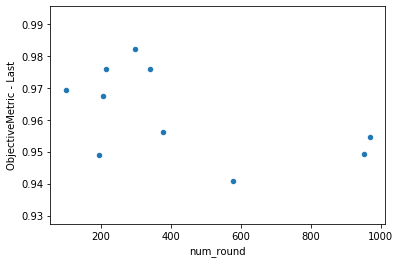

In [69]:
%matplotlib inline
dfplot=trial_component_analytics.dataframe()
dfplot.plot.scatter(x='num_round', y='ObjectiveMetric - Last')

## Deploy an Endpoint for the Best Training Job

In [70]:

tuner.best_training_job()

'Adult-HPO-XGBoost-1656959004-005-5810e862'

In [71]:

tuner_predictor = tuner.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')


2022-07-04 18:29:47 Starting - Preparing the instances for training
2022-07-04 18:29:47 Downloading - Downloading input data
2022-07-04 18:29:47 Training - Training image download completed. Training in progress.
2022-07-04 18:29:47 Uploading - Uploading generated training model
2022-07-04 18:29:47 Completed - Training job completed

INFO:sagemaker:Creating model with name: Adult-HPO-XGBoost-1656959004-005-5810e8-2022-07-04-19-16-19-203


INFO:sagemaker:Creating endpoint-config with name Adult-HPO-XGBoost-1656959004-005-5810e862
INFO:sagemaker:Creating endpoint with name Adult-HPO-XGBoost-1656959004-005-5810e862


-------!